# Machine Learning Lab-04: Experiment 3 - Logistic Regression

## Objective
Predict whether a user will click on an online ad based on demographics, browsing behavior, and time of day using Logistic Regression.

## Dataset
The dataset contains user demographic information, browsing habits, and details related to the display of the advertisement.
Link: [Kaggle Dataset](https://www.kaggle.com/datasets/gabrielsantello/advertisement-click-on-ad)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

%matplotlib inline
sns.set(style='whitegrid')

### a) Load and display the information about the dataset

In [2]:
# Load dataset
df = pd.read_csv('ad_click_prediction.csv')

# Display first 5 rows
print("First 5 rows:")
display(df.head())

# Display dataset info
print("\nDataset Info:")
df.info()

# Summary statistics
print("\nSummary Statistics:")
display(df.describe())

First 5 rows:


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.3+ KB

Summary Statistics:


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


### b) Exploratory Data Analysis (EDA)

Missing Values:
Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64


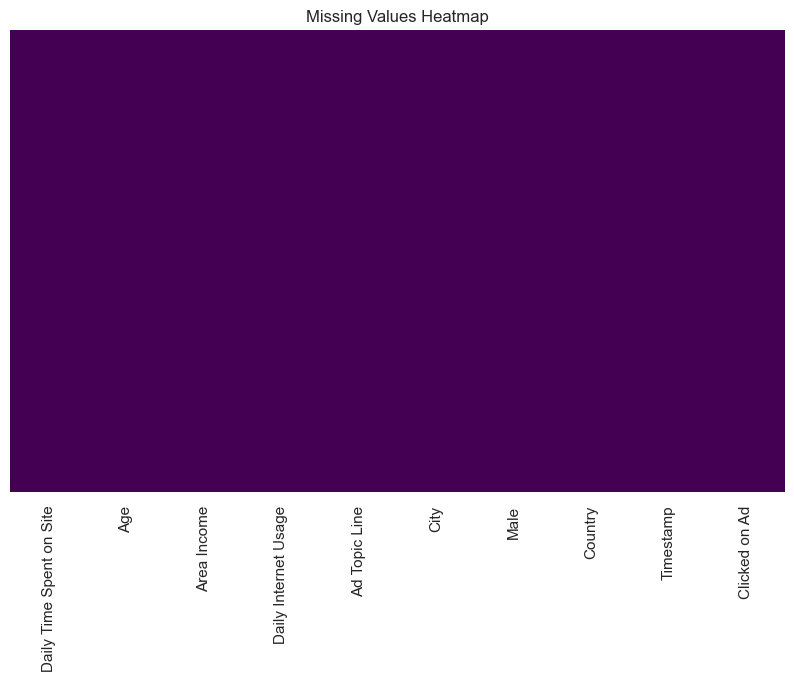

In [3]:
# 1. Missing Value Treatment
print("Missing Values:")
print(df.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [4]:
# 2. Data Transformation

# Convert 'Timestamp' to datetime object
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract 'Hour', 'Month', 'Day of Week' (Month and Day might be useful, but Hour is requested)
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

# Drop non-numerical/high-cardinality columns that are hard to encode simply for this lab
# 'Ad Topic Line', 'City', 'Country', 'Timestamp'
df_model = df.drop(['Ad Topic Line', 'City', 'Country', 'Timestamp'], axis=1)

print("Columns after transformation:")
print(df_model.columns)
display(df_model.head())

Columns after transformation:
Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Male', 'Clicked on Ad', 'Hour', 'Month',
       'DayOfWeek'],
      dtype='object')


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,Hour,Month,DayOfWeek
0,68.95,35,61833.90,256.09,0,0,0,3,6
1,80.23,31,68441.85,193.77,1,0,1,4,0
2,69.47,26,59785.94,236.50,0,0,20,3,6
3,74.15,29,54806.18,245.89,1,0,2,1,6
4,68.37,35,73889.99,225.58,0,0,3,6,4


In [5]:
# 3. Normalization
# It is good practice to normalize features for Logistic Regression
scaler = StandardScaler()
features_to_scale = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Hour']
df_model[features_to_scale] = scaler.fit_transform(df_model[features_to_scale])

print("Data after Normalization:")
display(df_model.head())

Data after Normalization:


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,Hour,Month,DayOfWeek
0,0.249267,-0.114905,0.509691,1.734030,0,0,-1.675896,3,6
1,0.961132,-0.570425,1.002530,0.313805,1,0,-1.532166,4,0
2,0.282083,-1.139826,0.356949,1.287589,0,0,1.198711,3,6
3,0.577432,-0.798185,-0.014456,1.501580,1,0,-1.388436,1,6
4,0.212664,-0.114905,1.408868,1.038731,0,0,-1.244705,6,4


### c) Find correlation among features and display Heatmap

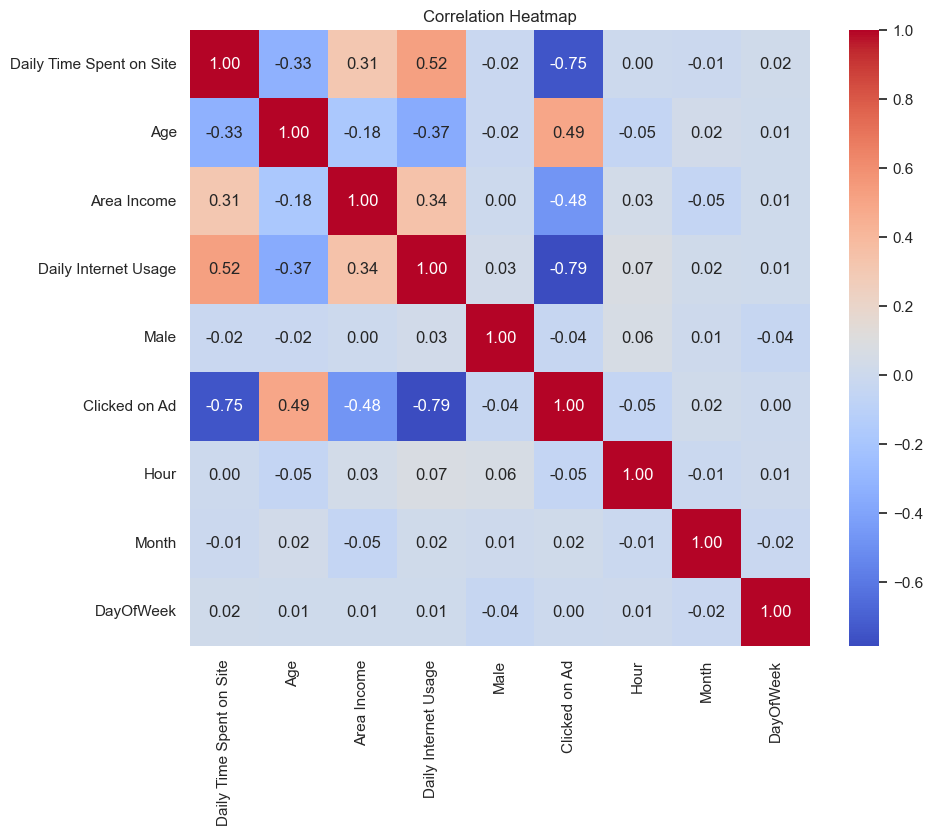

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_model.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### d) Train a Logistic Regression model (Train-Test Split 80:20)

In [7]:
X = df_model.drop('Clicked on Ad', axis=1)
y = df_model['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

print("Model Parameters:")
print(f"Intercept: {logmodel.intercept_}")
print(f"Coefficients: {logmodel.coef_}")

Model Parameters:
Intercept: [0.96218942]
Coefficients: [[-2.56712177  1.24838714 -1.66856502 -2.80877773 -0.59054522 -0.08357909
   0.13416285  0.11957303]]


### e) Apply K-fold cross validation split and record results

In [8]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
cv_results = cross_val_score(logmodel, X, y, cv=kfold, scoring='accuracy')

print(f"K-Fold CV Accuracy Scores: {cv_results}")
print(f"Mean Accuracy: {cv_results.mean():.4f}")
print(f"Standard Deviation: {cv_results.std():.4f}")

K-Fold CV Accuracy Scores: [0.98 0.93 0.99 0.97 0.99 0.98 0.95 0.98 0.97 0.97]
Mean Accuracy: 0.9710
Standard Deviation: 0.0176


### f) Display Classification Report (Precision, Recall, F1-score)

In [9]:
predictions = logmodel.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        89
           1       0.96      0.95      0.96       111

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



### g) Display Confusion Matrix, ROC Curve, Precision-Recall Curve

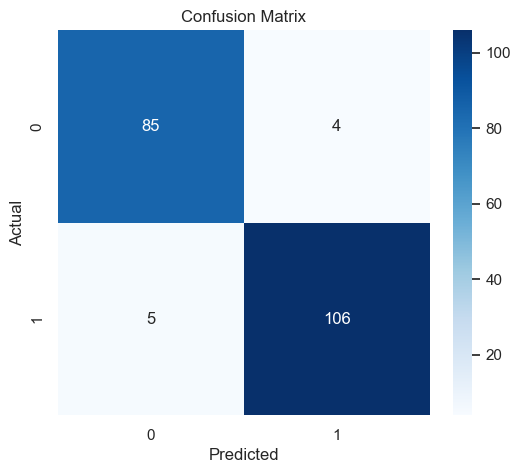

In [10]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

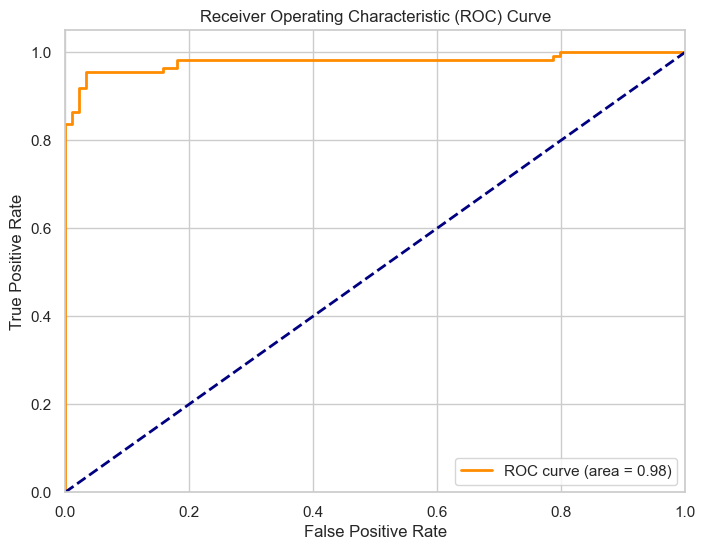

In [11]:
# ROC Curve
y_prob = logmodel.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

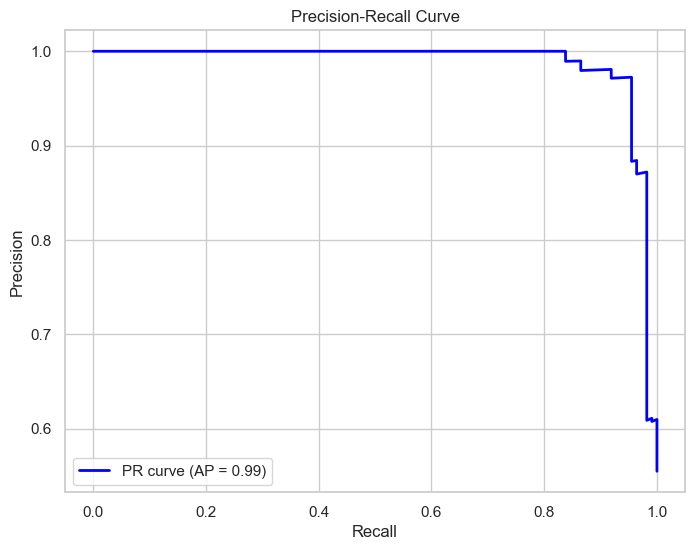

In [12]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### h) Visualize Predicted vs Actual outcome

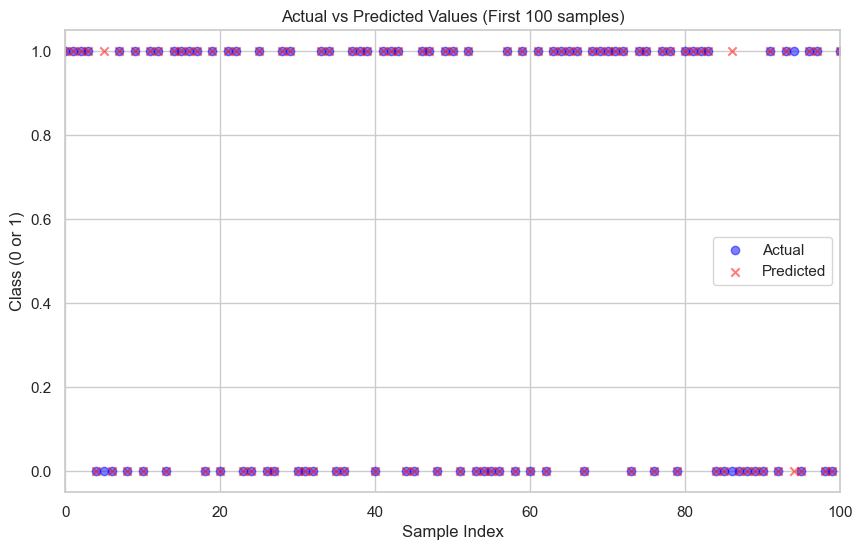

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.5, marker='o')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', alpha=0.5, marker='x')
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Class (0 or 1)')
plt.legend()
plt.xlim(0, 100) # Limit to first 100 for visibility
plt.show()